<h1>Word2Vec STS models - Mean approach</h1>

<p>Generate Word2vec embeddings for given corpus and average the embeddings to create sentence embeddings and apply following approaches for STS scores generation:</p>
<li>Normalized Cosine Similarity scores</li>
<li>Linear regression</li>
<li>BiGRU based implementation</li>
<li>BiLSTM based implementation</li>
<li>BiLSTM Self Attention based implementation</li>

<p>Observations: Dataset is less and hence all neural network models are overfitting</p>

In [1]:
import pandas as pd
import numpy as np

In [16]:
train_df = pd.read_csv('../data/cleaned_train_df.csv')
val_df = pd.read_csv('../data/cleaned_val_df.csv')
test_df = pd.read_csv('../data/cleaned_test_df.csv')

In [13]:
import numpy as np
import torch
import torch.nn as nn
from gensim.models import KeyedVectors

# load pre-trained Word2Vec model
model_path = "../../introduction_to_nlp/GoogleNews-vectors-negative300.bin"
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [17]:
train_df['sent1'] = train_df['sent1'].apply(eval)
train_df['sent2'] = train_df['sent2'].apply(eval)
train_sentences1 = list(train_df['sent1'])
train_sentences2 = list(train_df['sent2'])
train_similarity_scores = list(train_df['score'])

In [18]:
val_df['sent1'] = val_df['sent1'].apply(eval)
val_df['sent2'] = val_df['sent2'].apply(eval)
val_sentences1 = list(val_df['sent1'])
val_sentences2 = list(val_df['sent2'])
val_similarity_scores = list(val_df['score'])

In [19]:
test_df['sent1'] = test_df['sent1'].apply(eval)
test_df['sent2'] = test_df['sent2'].apply(eval)
test_sentences1 = list(test_df['sent1'])
test_sentences2 = list(test_df['sent2'])
test_similarity_scores = list(test_df['score'])

In [20]:
# define a function to generate sentence embeddings
def get_sentence_embedding(sentence, max_length=30):
    # split sentence into words
    #words = sentence.split()
    words = sentence
    # filter out words that are not present in the model's vocabulary
    words = [word for word in words if word in model.key_to_index]
    # generate word embeddings for each word
    embeddings = [model[word] for word in words]
    # pad embeddings with zeros if the sentence is shorter than max_length
    embedding = np.mean(embeddings, axis=0)
    return embedding

In [22]:
# generate sentence embeddings
train_X1 = np.array([get_sentence_embedding(sentence) for sentence in train_sentences1])
train_X2 = np.array([get_sentence_embedding(sentence) for sentence in train_sentences2])

In [24]:
train_X = np.concatenate([train_X1, train_X2], axis=1)

In [28]:
val_X1 = np.array([get_sentence_embedding(sentence) for sentence in val_sentences1])
val_X2 = np.array([get_sentence_embedding(sentence) for sentence in val_sentences2])

In [29]:
val_X = np.concatenate([val_X1, val_X2], axis=1)

In [36]:
# generate sentence embeddings
test_X1 = np.array([get_sentence_embedding(sentence) for sentence in test_sentences1])
test_X2 = np.array([get_sentence_embedding(sentence) for sentence in test_sentences2])

In [37]:
test_X = np.concatenate([test_X1, test_X2], axis=1)

In [31]:
def sts_score(sim_score):
    sts_score = (sim_score+1) * 2.5
    return sts_score

In [32]:
from scipy import spatial
from scipy.stats import pearsonr

def get_sts_scores(emb1_lt, emb2_lt):
    y_pred = []
    for i in range(len(emb1_lt)):
        sim_score = 1 - spatial.distance.cosine(emb1_lt[i], emb2_lt[i])
        y_pred.append(sts_score(sim_score))
    return y_pred
    
def pearson_corr(y_true, y_pred):
    """
    Calculate Pearson correlation coefficient between two arrays.
    """
    corr, _ = pearsonr(y_true, y_pred)
    return corr

# Normalized Cosine Similarity

In [33]:
train_y_pred = get_sts_scores(train_X1, train_X2)

In [34]:
val_y_pred = get_sts_scores(val_X1, val_X2)

In [38]:
test_y_pred = get_sts_scores(test_X1, test_X2)

In [39]:
corr = pearson_corr(train_similarity_scores, train_y_pred)
print("Pearson correlation coefficient: {:.2f}".format(corr))

Pearson correlation coefficient: 0.64


In [40]:
corr = pearson_corr(val_similarity_scores, val_y_pred)
print("Pearson correlation coefficient: {:.2f}".format(corr))

Pearson correlation coefficient: 0.68


In [41]:
corr = pearson_corr(test_similarity_scores, test_y_pred)
print("Pearson correlation coefficient: {:.2f}".format(corr))

Pearson correlation coefficient: 0.55


# Residual analysis

In [185]:
row_max_len = lambda row: max(len(row['sent1']), len(row['sent2']))

In [188]:
train_df['sent_len'] = train_df.apply(row_max_len, axis=1)

In [189]:
val_df['sent_len'] = val_df.apply(row_max_len, axis=1)

In [190]:
test_df['sent_len'] = test_df.apply(row_max_len, axis=1)

In [191]:
train_df['diff'] = abs(train_df['score'] - train_y_pred)

In [192]:
val_df['diff'] = abs(val_df['score'] - val_y_pred)

In [193]:
test_df['diff'] = abs(test_df['score'] - test_y_pred)

In [194]:
grouped_df = train_df.groupby(['sent_len']).mean()

/var/folders/gb/8lc9v2sx5mq19kgysgv67bzw0000gn/T/ipykernel_1636/1448148412.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = train_df.groupby(['sent_len']).mean()


In [195]:
grouped_df['sent_length'] = grouped_df.index

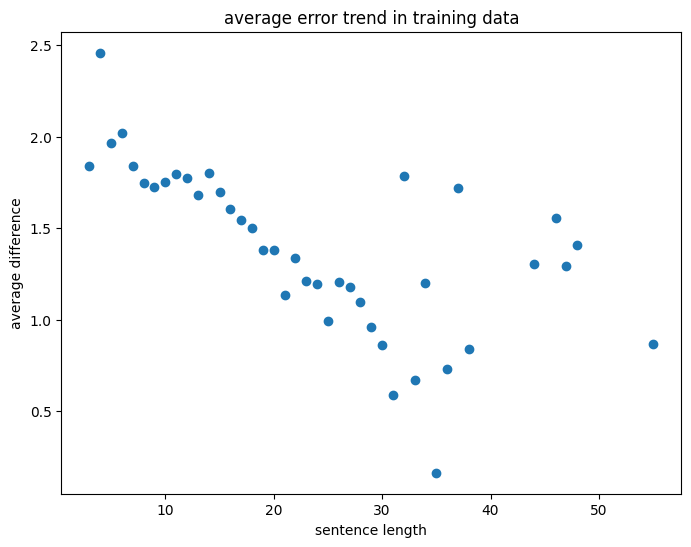

In [197]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(list(grouped_df.index), list(grouped_df['diff']))
plt.title("average error trend in training data")
plt.xlabel("sentence length")
plt.ylabel("average difference")
plt.show()

In [198]:
grouped_val = val_df.groupby(['sent_len']).mean()

/var/folders/gb/8lc9v2sx5mq19kgysgv67bzw0000gn/T/ipykernel_1636/640488790.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_val = val_df.groupby(['sent_len']).mean()


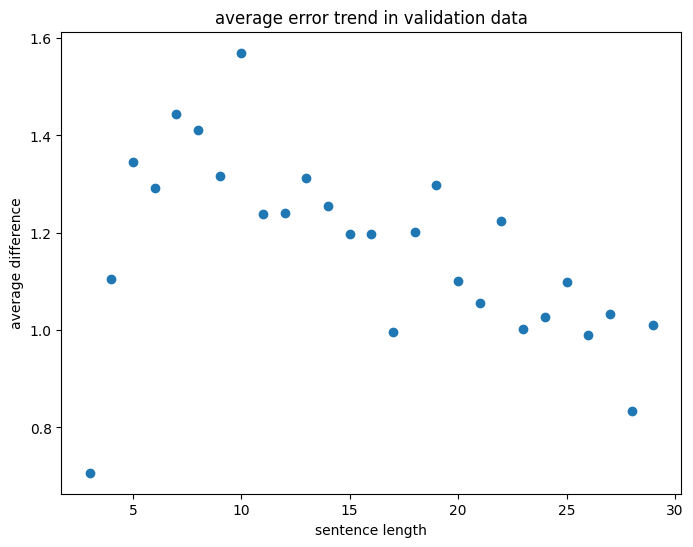

In [199]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(list(grouped_val.index), list(grouped_val['diff']))
plt.title("average error trend in validation data")
plt.xlabel("sentence length")
plt.ylabel("average difference")
plt.show()

In [200]:
grouped_test = test_df.groupby(['sent_len']).mean()

/var/folders/gb/8lc9v2sx5mq19kgysgv67bzw0000gn/T/ipykernel_1636/1156243688.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_test = test_df.groupby(['sent_len']).mean()


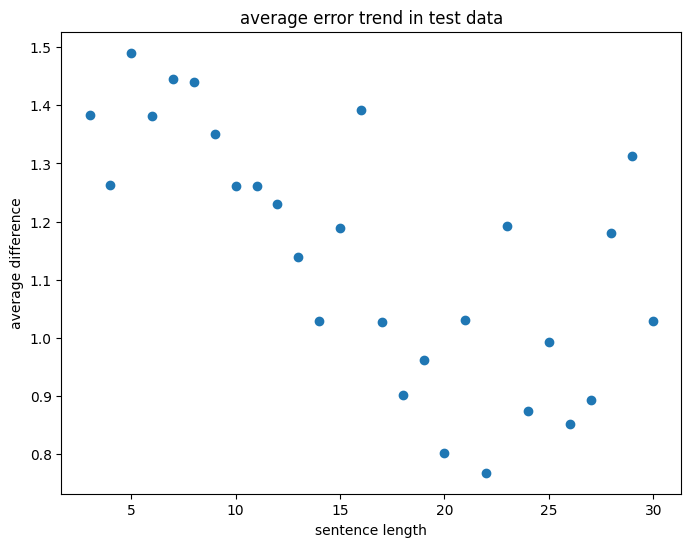

In [201]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(list(grouped_test.index), list(grouped_test['diff']))
plt.title("average error trend in test data")
plt.xlabel("sentence length")
plt.ylabel("average difference")
plt.show()

# Linear Regression

In [27]:
from sklearn.linear_model import LinearRegression
# train a linear regression model
reg = LinearRegression().fit(train_X, train_similarity_scores)

In [42]:
val_y_pred = reg.predict(val_X)

In [43]:
corr = pearson_corr(val_similarity_scores, val_y_pred)
print("Pearson correlation coefficient: {:.2f}".format(corr))

Pearson correlation coefficient: 0.16


In [44]:
test_y_pred = reg.predict(test_X)

In [45]:
corr = pearson_corr(test_similarity_scores, test_y_pred)
print("Pearson correlation coefficient: {:.2f}".format(corr))

Pearson correlation coefficient: 0.19


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

In [67]:
# Convert the data into PyTorch tensors
train_embeddings1 = torch.tensor(train_X1, dtype=torch.float)
train_embeddings2 = torch.tensor(train_X2, dtype=torch.float)
scores = torch.tensor(train_similarity_scores, dtype=torch.float)

In [68]:
val_embeddings1 = torch.tensor(val_X1, dtype=torch.float)
val_embeddings2 = torch.tensor(val_X2, dtype=torch.float)
val_scores = torch.tensor(val_similarity_scores, dtype=torch.float)

In [81]:
test_embeddings1 = torch.tensor(test_X1, dtype=torch.float)
test_embeddings2 = torch.tensor(test_X2, dtype=torch.float)
test_scores = torch.tensor(test_similarity_scores, dtype=torch.float)

In [351]:
# Define the hyperparameters
input_dim = 300 # The dimension of the sentence embeddings
hidden_dim = 150
lr = 0.001
num_epochs = 15
#batch_size = 10

In [352]:
# class BiLSTMRegression(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers):
#         super().__init__()
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
#         self.bilstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
#         self.fc = nn.Linear(hidden_dim*2, 1)

#     def forward(self, x1, x2):
#         x = torch.cat((x1, x2), dim=1)
#         x = x.view(len(x), 1, -1)
#         h0 = torch.zeros(self.num_layers*2, len(x), self.hidden_dim).to(x.device)
#         c0 = torch.zeros(self.num_layers*2, len(x), self.hidden_dim).to(x.device)
#         out, _ = self.bilstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out
    
class BiLSTMRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_prob):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob
        self.bilstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim*2, 1)

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)
        x = x.view(len(x), 1, -1)
        h0 = torch.zeros(self.num_layers*2, len(x), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers*2, len(x), self.hidden_dim).to(x.device)
        out, _ = self.bilstm(x, (h0, c0))
        out = self.dropout(out) # Apply dropout
        out = self.fc(out[:, -1, :])
        return out

    

class GRURegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, 1)

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)
        x = x.view(len(x), 1, -1)
        h0 = torch.zeros(self.num_layers*2, len(x), self.hidden_dim).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


class BiLSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, attention_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.attention_dim = attention_dim
        self.bilstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.attention = SelfAttention(hidden_dim*2, attention_dim, 1)
        #self.attention = nn.Linear(hidden_dim*2, attention_dim)
        #self.softmax = nn.Softmax(dim=1)
        self.fc = nn.Linear(hidden_dim*2, 1)

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)
        x = x.view(len(x), 1, -1)
        h0 = torch.zeros(self.num_layers*2, len(x), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers*2, len(x), self.hidden_dim).to(x.device)
        out, _ = self.bilstm(x, (h0, c0))
        #att_weights = self.softmax(self.attention(out))
        att_weights = self.attention(out)
        out = torch.sum(out * att_weights, dim=1)
        out = self.fc(out)
        return out

class SelfAttention(nn.Module):
    """
    Implementation of the attention block
    """

    def __init__(self, input_size, hidden_size, output_size):
        super(SelfAttention, self).__init__()
        # TODO implement

        # constructing linear layers with weights analogous to Ws1 and Ws2
        self.layer1 = nn.Linear(input_size, hidden_size, bias=False)
        self.layer2 = nn.Linear(hidden_size, output_size, bias=False)
        self.softmax = nn.Softmax(dim=1)

    ## the forward function would receive lstm's all hidden states as input
    def forward(self, attention_input):
        # TODO implement

        # implementing the attention mechanism
        output = self.layer1(attention_input)
        output = torch.tanh(output)
        output = self.layer2(output)
        #output = F.softmax(output.transpose(1,2), dim=2)
        output = self.softmax(output)

        return output

In [353]:
model = GRURegression(input_dim*2, hidden_dim, num_layers=2)
#model = BiLSTMRegression(input_dim*2, hidden_dim, num_layers=2, dropout_prob = 0.3)
#model = BiLSTMAttention(input_dim*2, hidden_dim, num_layers=2, attention_dim=600)

In [354]:
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# Define the loss function
loss_fn = nn.MSELoss()

In [335]:
import torch.utils.data as data

# Define a custom dataset class
class SentenceSimilarityDataset(data.Dataset):
    def __init__(self, embeddings1, embeddings2, scores):
        self.embeddings1 = embeddings1
        self.embeddings2 = embeddings2
        self.scores = scores

    def __len__(self):
        return len(self.embeddings1)

    def __getitem__(self, index):
        return self.embeddings1[index], self.embeddings2[index], self.scores[index]

In [336]:
# Create the dataset
train_dataset = SentenceSimilarityDataset(train_embeddings1, train_embeddings2, scores)
val_dataset = SentenceSimilarityDataset(val_embeddings1, val_embeddings2, val_scores)

In [337]:
# Define the batch size
batch_size = 10

# Create the DataLoader
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [355]:
def train(model, optimizer, num_epochs, train_dataloader, val_dataloader):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            embeddings1_batch, embeddings2_batch, scores_batch = batch
            output = model(embeddings1_batch, embeddings2_batch)
            loss = loss_fn(output.squeeze(), scores_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(embeddings1_batch)
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

    # Evaluate the model on the validation set
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                embeddings1_batch, embeddings2_batch, scores_batch = batch
                val_output = model(embeddings1_batch, embeddings2_batch)
                val_loss += loss_fn(val_output.squeeze(), scores_batch).item() * len(embeddings1_batch)
            val_loss /= len(val_dataloader)
            val_losses.append(val_loss)

        print('Epoch {} - Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch+1, train_loss, val_loss))
    return train_losses, val_losses

In [356]:
train_losses, val_losses = train(model, optimizer, num_epochs, train_dataloader, val_dataloader)

Epoch 1 - Training Loss: 21.8529, Validation Loss: 23.2094
Epoch 2 - Training Loss: 19.3835, Validation Loss: 25.6779
Epoch 3 - Training Loss: 18.6548, Validation Loss: 22.0409
Epoch 4 - Training Loss: 17.5821, Validation Loss: 22.4292
Epoch 5 - Training Loss: 16.4598, Validation Loss: 23.0729
Epoch 6 - Training Loss: 14.9232, Validation Loss: 20.3532
Epoch 7 - Training Loss: 13.7784, Validation Loss: 20.4192
Epoch 8 - Training Loss: 12.7430, Validation Loss: 20.7099
Epoch 9 - Training Loss: 11.7858, Validation Loss: 20.5297
Epoch 10 - Training Loss: 10.9526, Validation Loss: 20.0335
Epoch 11 - Training Loss: 9.9446, Validation Loss: 20.8700
Epoch 12 - Training Loss: 9.1429, Validation Loss: 21.0070
Epoch 13 - Training Loss: 8.4324, Validation Loss: 20.8112
Epoch 14 - Training Loss: 7.7174, Validation Loss: 20.1883
Epoch 15 - Training Loss: 7.0928, Validation Loss: 21.1656


In [ ]:
#BiGRU Analysis

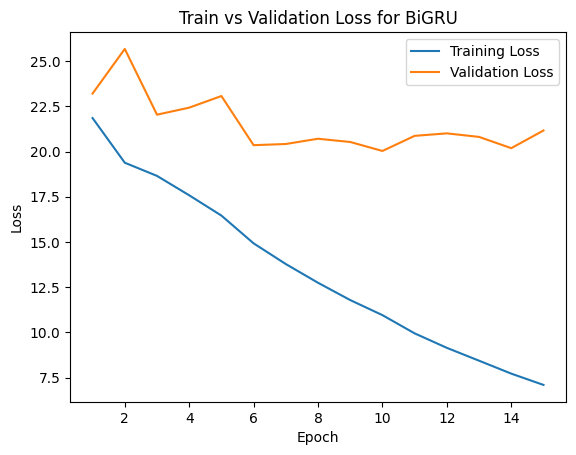

	 More Data needed	


In [359]:
import matplotlib.pyplot as plt



# Define the data
epochs = range(1, 16)
#train_losses = train_loss
#val_losses = val_loss

# Plot the data
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss for BiGRU')

# Add legend
plt.legend()

# Show the plot
plt.show()
print("\t More Data needed\t")

In [360]:
y_pred = evaluate(model, train_embeddings1, train_embeddings2)
corr = pearson_corr(train_similarity_scores, y_pred)
print("Pearson correlation coefficient: {:.2f}".format(corr))

Pearson correlation coefficient: 0.86


In [361]:
y_pred = evaluate(model, val_embeddings1, val_embeddings2)
corr = pearson_corr(val_similarity_scores, y_pred)
print("Pearson correlation coefficient: {:.2f}".format(corr))

Pearson correlation coefficient: 0.40


In [357]:
y_pred_test = evaluate(model, test_embeddings1, test_embeddings2)
corr = pearson_corr(test_similarity_scores, y_pred_test)
print("Pearson correlation coefficient: {:.2f}".format(corr))

Pearson correlation coefficient: 0.39


In [ ]:
#BiLstm Analysis

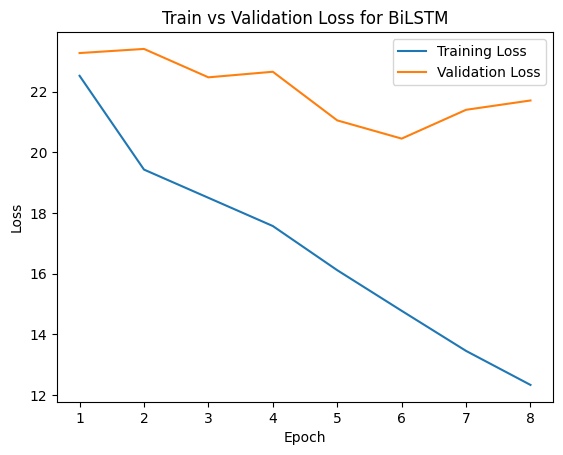

	 Overfitting due to model complexity	


In [340]:
import matplotlib.pyplot as plt



# Define the data
epochs = range(1, 9)
#train_losses = train_loss
#val_losses = val_loss

# Plot the data
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss for BiLSTM')

# Add legend
plt.legend()

# Show the plot
plt.show()
print("\t Overfitting due to model complexity\t")

In [341]:
y_pred = evaluate(model, train_embeddings1, train_embeddings2)
corr = pearson_corr(train_similarity_scores, y_pred)
print("Pearson correlation coefficient: {:.2f}".format(corr))

Pearson correlation coefficient: 0.71


In [342]:
y_pred = evaluate(model, val_embeddings1, val_embeddings2)
corr = pearson_corr(val_similarity_scores, y_pred)
print("Pearson correlation coefficient: {:.2f}".format(corr))

Pearson correlation coefficient: 0.35


In [343]:
y_pred_test = evaluate(model, test_embeddings1, test_embeddings2)
corr = pearson_corr(test_similarity_scores, y_pred_test)
print("Pearson correlation coefficient: {:.2f}".format(corr))

Pearson correlation coefficient: 0.38


In [230]:
len(train_losses), len(val_losses)

(30, 30)

In [245]:
# BiLSTM Attention analysis

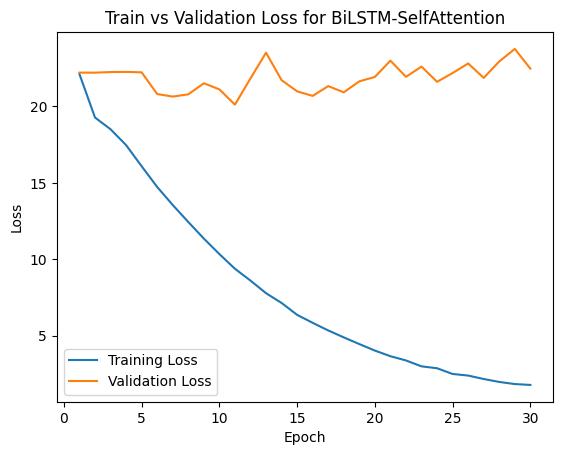

	 Overfitting due to model complexity	


In [235]:
import matplotlib.pyplot as plt



# Define the data
epochs = range(1, 31)
#train_losses = train_loss
#val_losses = val_loss

# Plot the data
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss for BiLSTM-SelfAttention')

# Add legend
plt.legend()

# Show the plot
plt.show()
print("\t Overfitting due to model complexity\t")

In [ ]:
# Apply on train and validation data

In [241]:
def evaluate(model, emb1, emb2):
    model.eval()
    with torch.no_grad():
        test_output = model(emb1, emb2)
    y_pred_test = test_output.squeeze().tolist()
    return y_pred_test

In [243]:
y_pred = evaluate(model, train_embeddings1, train_embeddings2)
corr = pearson_corr(train_similarity_scores, y_pred)
print("Pearson correlation coefficient: {:.2f}".format(corr))

Pearson correlation coefficient: 0.97


In [244]:
y_pred = evaluate(model, val_embeddings1, val_embeddings2)
corr = pearson_corr(val_similarity_scores, y_pred)
print("Pearson correlation coefficient: {:.2f}".format(corr))

Pearson correlation coefficient: 0.38


In [242]:
y_pred_test = evaluate(model, test_embeddings1, test_embeddings2)
corr = pearson_corr(test_similarity_scores, y_pred_test)
print("Pearson correlation coefficient: {:.2f}".format(corr))

Pearson correlation coefficient: 0.34
